<a href="https://colab.research.google.com/github/Saba-a11/Kaggle_Credit_Score/blob/main/CreditModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from ast import increment_lineno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline


# numbers and plot formatting
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))
sns.set_palette('plasma')    # magma, crest, rocket_r, flare, mako, rocket, viridis, plasma, cividis
sns.set_style('whitegrid')


def prt_corr(df, column_of_interest, target_column):
  # Calculate the correlation
  correlation = df[column_of_interest].corr(df[target_column])
  print(f"Correlation between {column_of_interest} and {target_column}: {correlation}")


def scatter_plot(df, column_of_interest, target_column):
  # Scatter plot
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=df[column_of_interest], y=df[target_column])
  plt.title(f'Scatter Plot between {column_of_interest} and {target_column}')
  plt.xlabel(column_of_interest)
  plt.ylabel(target_column)
  plt.show()


# def box_plot(df, xcol, ycol):
#   # Create a boxplot
#   plt.figure(figsize=(10, 6))
#   sns.boxplot(x=xcol, y=ycol, data=df, palette="Set1")
#   plt.xlabel(xcol)
#   plt.ylabel(ycol)
#   plt.title(f"Boxplot of {xcol} by {ycol}")
#   plt.show()


def box_plot(df, column_of_interest):
  # Assuming combined_data is your DataFrame
  plt.figure(figsize=(10, 6))
  sns.boxplot(x=df[column_of_interest], palette="Set1")
  plt.title(f'Boxplot for {column_of_interest}')
  plt.xlabel(column_of_interest)
  plt.show()


def heatmap_plot(df):
  # Create a heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(df, annot=True, cmap='coolwarm', linewidths=.5)
  plt.title('Heatmap for the Dataset')
  plt.show()

# Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [107]:
df_train = pd.read_csv("/content/drive/MyDrive/Data_Kaggle_GiveMeSomeCredit/cs-training.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Data_Kaggle_GiveMeSomeCredit/cs-test.csv")

In [4]:
df_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.77,45,2,0.80,"9,120.00",13,0,6,0,2.00
1,2,0,0.96,40,0,0.12,"2,600.00",4,0,0,0,1.00
2,3,0,0.66,38,1,0.09,"3,042.00",2,1,0,0,0.00
3,4,0,0.23,30,0,0.04,"3,300.00",5,0,0,0,0.00
4,5,0,0.91,49,1,0.02,"63,588.00",7,0,1,0,0.00


In [5]:
df_test.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.89,43,0,0.18,"5,700.00",4,0,0,0,0.00
1,2,NaN,0.46,57,0,0.53,"9,141.00",15,0,4,0,2.00
2,3,NaN,0.04,59,0,0.69,"5,083.00",12,0,1,0,2.00
3,4,NaN,0.28,38,1,0.93,"3,200.00",7,0,2,0,0.00
4,5,NaN,1.00,27,0,0.02,"3,865.00",4,0,0,0,1.00


### based on Data Dictionary, Variable Name, Description and Type are:

* `SeriousDlqin2yrs` Person experienced 90 days past due delinquency or
worse. **Y/N**
* `RevolvingUtilizationOfUnsecuredLines` Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits. **percentage**
* `age` Age of borrower in years. **integer**
* `NumberOfTime3059DaysPastDueNotWorse` Number of times borrower has been 30-59 days past due but no worse in the last 2 years. **integer**
* `DebtRatio` Monthly debt payments, alimony,living costs divided by monthy gross income **percentage**
* `MonthlyIncome Monthly` income **real**
* `NumberOfOpenCreditLinesAndLoans` Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) **integer**
* `NumberOfTimes90DaysLate` Number of times borrower has been 90 days or more past due. **integer**
* `NumberRealEstateLoansOrLines` Number of mortgage and real estate loans including home equity lines of credit **integer**
* `NumberOfTime60-89DaysPastDueNotWorse` Number of times borrower has been 60-89 days past due but no worse in the last 2 years. **integer**
* `NumberOfDependents` Number of dependents in family excluding themselves (spouse, children etc.) **integer**

# Exploratory Data Analysis

In [6]:
print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Train shape:  (150000, 12)
Test shape:  (101503, 12)


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [8]:
df_train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,"150,000.00","150,000.00","150,000.00","150,000.00","150,000.00","150,000.00","120,269.00","150,000.00","150,000.00","150,000.00","150,000.00","146,076.00"
mean,"75,000.50",0.07,6.05,52.30,0.42,353.01,"6,670.22",8.45,0.27,1.02,0.24,0.76
std,"43,301.41",0.25,249.76,14.77,4.19,"2,037.82","14,384.67",5.15,4.17,1.13,4.16,1.12
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"37,500.75",0.00,0.03,41.00,0.00,0.18,"3,400.00",5.00,0.00,0.00,0.00,0.00
50%,"75,000.50",0.00,0.15,52.00,0.00,0.37,"5,400.00",8.00,0.00,1.00,0.00,0.00
75%,"112,500.25",0.00,0.56,63.00,0.00,0.87,"8,249.00",11.00,0.00,2.00,0.00,1.00
max,"150,000.00",1.00,"50,708.00",109.00,98.00,"329,664.00","3,008,750.00",58.00,98.00,54.00,98.00,20.00


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            101503 non-null  int64  
 1   SeriousDlqin2yrs                      0 non-null       float64
 2   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 3   age                                   101503 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 5   DebtRatio                             101503 non-null  float64
 6   MonthlyIncome                         81400 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 8   NumberOfTimes90DaysLate               101503 non-null  int64  
 9   NumberRealEstateLoansOrLines          101503 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 11  

In [10]:
df_test.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,"101,503.00",0.00,"101,503.00","101,503.00","101,503.00","101,503.00","81,400.00","101,503.00","101,503.00","101,503.00","101,503.00","98,877.00"
mean,"50,752.00",NaN,5.31,52.41,0.45,344.48,"6,855.04",8.45,0.30,1.01,0.27,0.77
std,"29,301.54",NaN,196.16,14.78,4.54,"1,632.60","36,508.60",5.14,4.52,1.11,4.50,1.14
min,1.00,NaN,0.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"25,376.50",NaN,0.03,41.00,0.00,0.17,"3,408.00",5.00,0.00,0.00,0.00,0.00
50%,"50,752.00",NaN,0.15,52.00,0.00,0.36,"5,400.00",8.00,0.00,1.00,0.00,0.00
75%,"76,127.50",NaN,0.56,63.00,0.00,0.85,"8,200.00",11.00,0.00,2.00,0.00,1.00
max,"101,503.00",NaN,"21,821.00",104.00,98.00,"268,326.00","7,727,000.00",85.00,98.00,37.00,98.00,43.00


## EDA Results:


* `Unnamed: 0`:
    * Customer Identifier
    * Rename: ID
    * Irrelevant in modeling
* `SeriousDlqin2yrs`:
    * Encoded as 0 for No, 1 for Yes.
    * Negative to positive delinquency outliers: 93.3% to 6.7%.
    * Target feature highly imbalanced and need to manage by some strategies.
* `RevolvingUtilizationOfUnsecuredLines`:
    * Distribution has Right-skewed values.
    * Anticipate increased defaults with rising ratios.
    * Values higher than 1 seem outlier.
* `age`:
    * Minimum Age set at 0, considered incorrect.
    * Maximum age at 109, deemed peculiar.

**Overdue Payment Indicators:**
* `NumberOfTime30-59DaysPastDueNotWorse`
* `NumberOfTime60-89DaysPastDueNotWorse`
* `NumberOfTimes90DaysLate`
    * The outlier intervention in our indicators. numbers 96 and 98 appears repeatedly.
    * A percentile 99% of our values hovered around 2 and 3, and anything beyond felt like an outlier.
* `DebtRatio`:
    * Distribution has Right-skewed values.
    * Values higher than 1 seem outlier.
    * A zero ratio is deemed dangerous and needs management.
    * Anticipate decrease defaults with rising ratios.
* `MonthlyIncome`:
    * Exhibit null values, necessitating appropriate handling procedures.
* `NumberOfOpenCreditLinesAndLoans`:
    * Maximum number points to outliers.
    * outliers seem in this feature, 75% of the feature lies below 11.
* `umberRealEstateLoansOrLines`:
    * Maximum number points to outliers.
    * outliers seem in this feature, 95% of the feature lies below 3.
* `NumberOfDependents`:
    * Exhibit null values, necessitating appropriate handling procedures.


* The preliminary analysis of the **train** and **test** datasets indicates a congruent behavior between the two. Consequently, we opt to merge them during the data preprocessing phase for streamlined processing and analysis.



# Data Preprocessing

### Unnamed: 0 Column

The column labeled `Unnamed: 0` lacks significance within the context of predictive modeling, serving solely as a representation of customer identification. Rename this column to `ID` for future reference, It will not play a role in the modeling process.

In [108]:
df_train.rename(columns={'Unnamed: 0':'ID'}, inplace=True)
df_test.rename(columns={'Unnamed: 0':'ID'}, inplace=True)

### SeriousDlqin2yrs Column

An imbalanced target column in a dataset, particularly in the context of binary classification, implies that the distribution of the classes is uneven. `SeriousDlqin2yrs` column has an imbalance, with a default rate of **6.7%**.

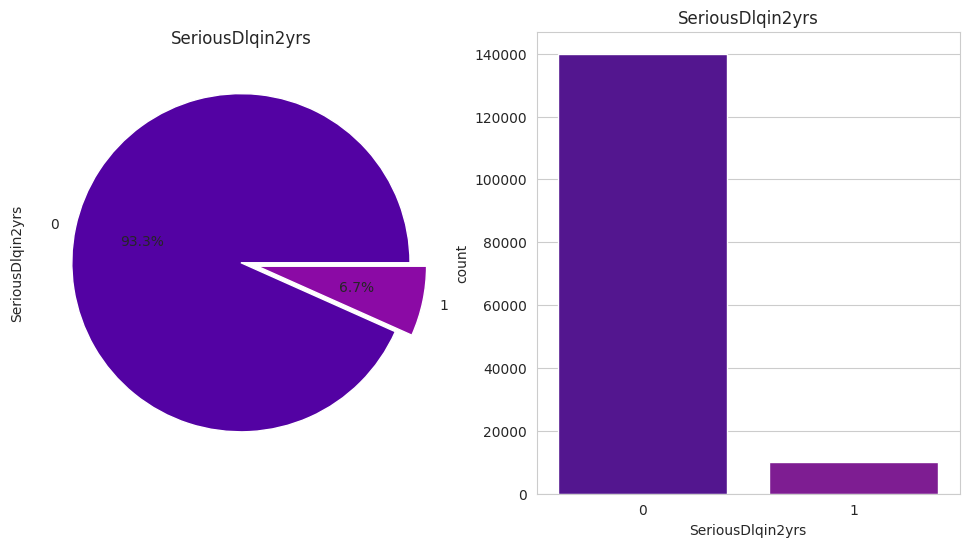

In [17]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

df_train['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=axes[0])
axes[0].set_title('SeriousDlqin2yrs')

sns.countplot(x='SeriousDlqin2yrs', data=df_train, ax=axes[1])
axes[1].set_title('SeriousDlqin2yrs')

plt.show()

In [109]:
# Assuming train and test are dataframes
# Add a column to each indicating their origin

df_train['dataset'] = 'train'
df_test['dataset'] = 'test'

# Concatenate the two dataframes
combined_data = pd.concat([df_train, df_test], ignore_index=True)

In [19]:
print('Combined data shape: ', combined_data.shape)

Combined data shape:  (251503, 13)


In [20]:
# check if exist any duplicated data
print(combined_data.duplicated().value_counts())

False    251503
dtype: int64


### RevolvingUtilizationOfUnsecuredLines Column

In [28]:
combined_data[["RevolvingUtilizationOfUnsecuredLines"]].describe()

,RevolvingUtilizationOfUnsecuredLines
count,"251,503.00"
mean,0.32
std,0.35
min,0.00
25%,0.03
50%,0.15
75%,0.56
max,1.00


In [110]:
prt_corr(combined_data,'RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

Correlation between RevolvingUtilizationOfUnsecuredLines and SeriousDlqin2yrs: -0.0018015025039439683


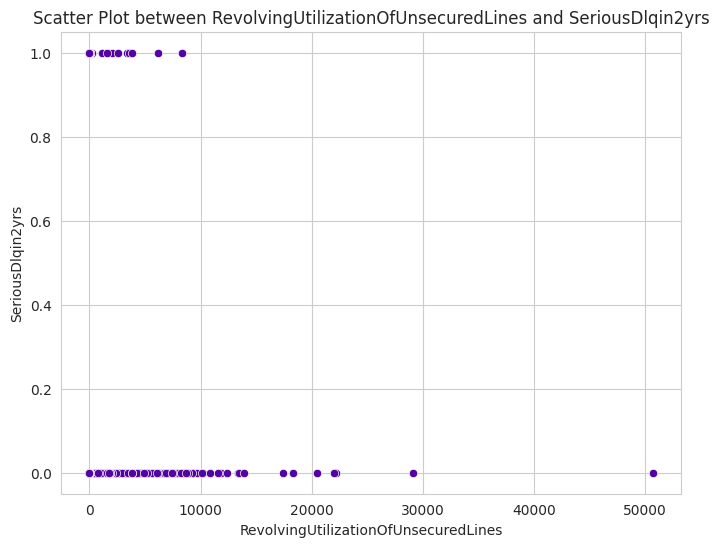

In [44]:
scatter_plot(combined_data,'RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

In [45]:
print("Number of RevolvingUtilizationOfUnsecuredLines that are more than 1:", len(combined_data[combined_data['RevolvingUtilizationOfUnsecuredLines'] > 1]))

Number of RevolvingUtilizationOfUnsecuredLines that are more than 1: 5502


In [111]:
combined_data['RevolvingUtilizationOfUnsecuredLines'] = combined_data['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x: 1 if x > 1 else x)

combined_data[['RevolvingUtilizationOfUnsecuredLines']].describe()

,RevolvingUtilizationOfUnsecuredLines
count,"251,503.00"
mean,0.32
std,0.35
min,0.00
25%,0.03
50%,0.15
75%,0.56
max,1.00


In [112]:
prt_corr(combined_data,'RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

Correlation between RevolvingUtilizationOfUnsecuredLines and SeriousDlqin2yrs: 0.27809636823708855


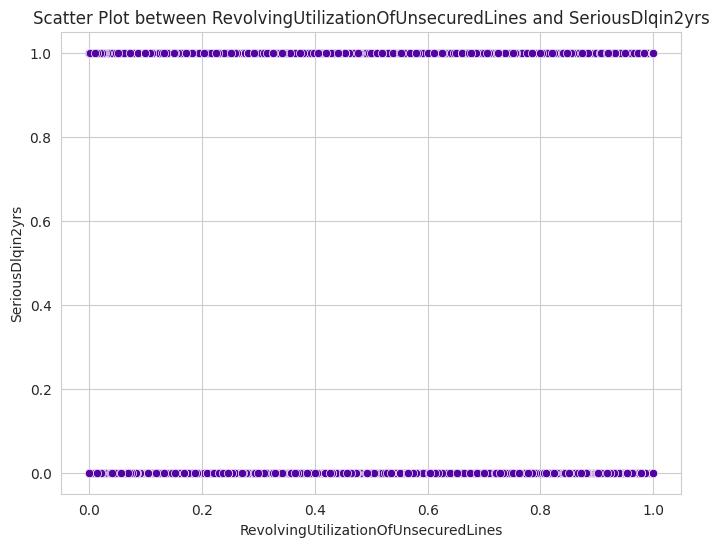

In [48]:
scatter_plot(combined_data,'RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

### Age Column

In [49]:
combined_data[["age"]].describe()

,age
count,"251,503.00"
mean,52.34
std,14.78
min,0.00
25%,41.00
50%,52.00
75%,63.00
max,109.00


In [70]:
zero_age_count = (combined_data['age'] == 0).sum()
print(f"Number of values equal to zero in the 'age' column: {zero_age_count}")

Number of values equal to zero in the 'age' column: 1


In [113]:
# Impute age=0 with the median age
median_age = combined_data['age'].median()
combined_data['age'] = combined_data['age'].replace(0, median_age)

In [114]:
prt_corr(combined_data, 'age', 'SeriousDlqin2yrs')

Correlation between age and SeriousDlqin2yrs: -0.11539662019283052


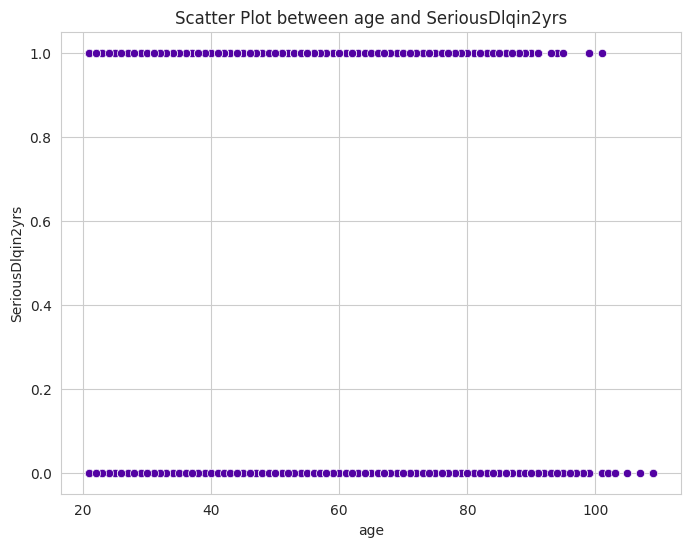

In [53]:
scatter_plot(combined_data, 'age', 'SeriousDlqin2yrs')

### Overdue Payment Indicators

* `NumberOfTimes90DaysLate`
* `NumberOfTime60-89DaysPastDueNotWorse`
* `NumberOfTime30-59DaysPastDueNotWorse`

In [72]:
late_pay_cols = ["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate"]
combined_data[late_pay_cols].describe()

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,"251,503.00","251,503.00","251,503.00"
mean,0.43,0.25,0.28
std,4.34,4.30,4.31
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,0.00,0.00,0.00
max,98.00,98.00,98.00


In [73]:
# Calculate the correlation
df_corr = combined_data[["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "SeriousDlqin2yrs"]]

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Print the correlation matrix
print(correlation_matrix.to_string())

                                      NumberOfTime30-59DaysPastDueNotWorse  NumberOfTime60-89DaysPastDueNotWorse  NumberOfTimes90DaysLate  SeriousDlqin2yrs
NumberOfTime30-59DaysPastDueNotWorse                                  1.00                                  0.99                     0.98              0.13
NumberOfTime60-89DaysPastDueNotWorse                                  0.99                                  1.00                     0.99              0.10
NumberOfTimes90DaysLate                                               0.98                                  0.99                     1.00              0.12
SeriousDlqin2yrs                                                      0.13                                  0.10                     0.12              1.00


In [74]:
# Create three tables
count_90_days = combined_data["NumberOfTimes90DaysLate"].value_counts().sort_index()
count_60_89_days = combined_data["NumberOfTime60-89DaysPastDueNotWorse"].value_counts().sort_index()
count_30_59_days = combined_data["NumberOfTime30-59DaysPastDueNotWorse"].value_counts().sort_index()

# Concatenate the value counts into a single DataFrame
result_df = pd.concat([count_90_days, count_60_89_days, count_30_59_days], axis=1)

# Rename the columns for clarity
result_df.columns = ['NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse']

# Display the resulting DataFrame
print(result_df.to_string())

    NumberOfTimes90DaysLate  NumberOfTime60-89DaysPastDueNotWorse  NumberOfTime30-59DaysPastDueNotWorse
0                237,447.00                            238,771.00                            211,208.00
1                  8,837.00                              9,594.00                             26,870.00
2                  2,617.00                              1,849.00                              7,766.00
3                  1,112.00                                534.00                              2,955.00
4                    482.00                                166.00                              1,257.00
5                    233.00                                 59.00                                547.00
6                    124.00                                 23.00                                228.00
7                     64.00                                 16.00                                 96.00
8                     40.00                                  3.0

In [115]:
combined_data[late_pay_cols].describe([0.25, 0.5, 0.75, 0.8, 0.85, 0.90, 0.95, 0.99])

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,"251,503.00","251,503.00","251,503.00"
mean,0.43,0.25,0.28
std,4.34,4.30,4.31
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,0.00,0.00,0.00
80%,0.00,0.00,0.00
85%,1.00,0.00,0.00
90%,1.00,0.00,0.00


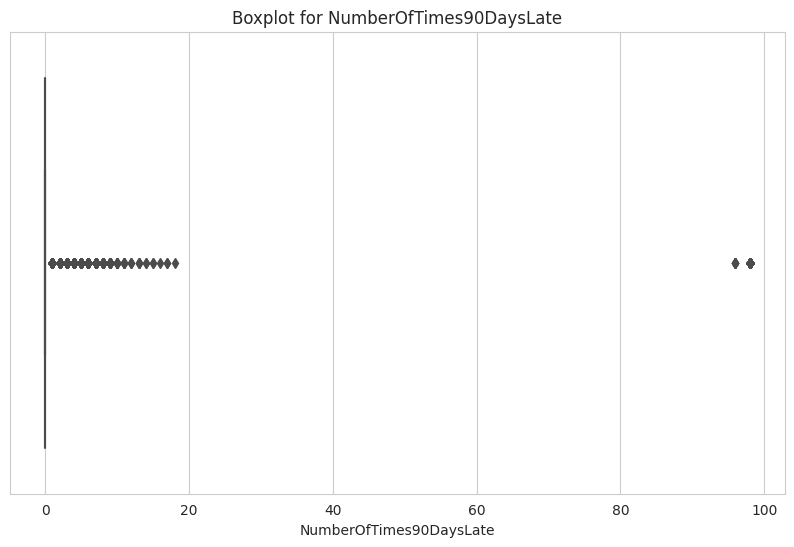

In [76]:
box_plot(combined_data, 'NumberOfTimes90DaysLate')

In [116]:
# Set upper bound
def upper_bound(col):
  upper_bound = combined_data[col].quantile(0.99)
  # Apply winsorizing using .loc[]
  combined_data.loc[combined_data[col] > upper_bound, col] = upper_bound

upper_bound('NumberOfTime30-59DaysPastDueNotWorse')
upper_bound('NumberOfTime60-89DaysPastDueNotWorse')
upper_bound('NumberOfTimes90DaysLate')

In [117]:
# Calculate the correlation
df_corr = combined_data[["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "SeriousDlqin2yrs"]]

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Print the correlation matrix
print(correlation_matrix.to_string())

                                      NumberOfTime30-59DaysPastDueNotWorse  NumberOfTime60-89DaysPastDueNotWorse  NumberOfTimes90DaysLate  SeriousDlqin2yrs
NumberOfTime30-59DaysPastDueNotWorse                                  1.00                                  0.36                     0.30              0.29
NumberOfTime60-89DaysPastDueNotWorse                                  0.36                                  1.00                     0.38              0.29
NumberOfTimes90DaysLate                                               0.30                                  0.38                     1.00              0.35
SeriousDlqin2yrs                                                      0.29                                  0.29                     0.35              1.00


In [118]:
# Coefficients for weighting
coefficients = {
    'NumberOfTime30-59DaysPastDueNotWorse': 1,
    'NumberOfTime60-89DaysPastDueNotWorse': 2,
    'NumberOfTimes90DaysLate': 3
}

# Create the weighted average column
combined_data['OverduePaymentIndicatorsWeightedAverage'] = (
    combined_data['NumberOfTime30-59DaysPastDueNotWorse'] * coefficients['NumberOfTime30-59DaysPastDueNotWorse'] +
    combined_data['NumberOfTime60-89DaysPastDueNotWorse'] * coefficients['NumberOfTime60-89DaysPastDueNotWorse'] +
    combined_data['NumberOfTimes90DaysLate'] * coefficients['NumberOfTimes90DaysLate']
) / sum(coefficients.values())

In [119]:
prt_corr(combined_data, 'OverduePaymentIndicatorsWeightedAverage', 'SeriousDlqin2yrs')

Correlation between OverduePaymentIndicatorsWeightedAverage and SeriousDlqin2yrs: 0.41473347921069065


In [120]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
combined_data['OverduePaymentIndicatorsPCA'] = pca.fit_transform(combined_data[['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']])


In [121]:
prt_corr(combined_data, 'OverduePaymentIndicatorsPCA', 'SeriousDlqin2yrs')

Correlation between OverduePaymentIndicatorsPCA and SeriousDlqin2yrs: 0.33805779917564893


### DebtRatio

In [93]:
combined_data[["DebtRatio"]].describe()

,DebtRatio
count,"251,503.00"
mean,349.56
std,"1,884.79"
min,0.00
25%,0.17
50%,0.37
75%,0.86
max,"329,664.00"


**Minimum (min):** The minimum DebtRatio is 0. This suggests that there are entries where the debt payments, alimony, and living costs are effectively zero or extremely low compared to the gross income percentage.

**Maximum (max):** The maximum DebtRatio is very high at 329,664. This suggests the presence of outliers in the data.

In [122]:
pd.concat([combined_data.loc[combined_data["DebtRatio"] == 0][["MonthlyIncome"]].describe().rename(columns={"MonthlyIncome": "MonthlyIncome (DebtRatio = 0)"}), combined_data[["MonthlyIncome"]].describe()], axis=1)

,MonthlyIncome (DebtRatio = 0),MonthlyIncome
count,"4,143.00","201,669.00"
mean,"4,154.11","6,744.82"
std,"12,338.29","25,717.61"
min,0.00,0.00
25%,"1,630.50","3,400.00"
50%,"3,000.00","5,400.00"
75%,"5,000.00","8,212.00"
max,"629,000.00","7,727,000.00"


In [123]:
pd.concat([combined_data.loc[combined_data["DebtRatio"] == 0][["age"]].describe().rename(columns={"age": "age (DebtRatio = 0)"}), combined_data[["age"]].describe()], axis=1)

,age (DebtRatio = 0),age
count,"6,888.00","251,503.00"
mean,52.51,52.34
std,21.27,14.77
min,21.00,21.00
25%,32.00,41.00
50%,52.00,52.00
75%,70.00,63.00
max,103.00,109.00


No significant difference was observed.

Given that 75% of the entries with `DebtRatio` equal to 0 have a `MonthlyIncome` below 5,000, it suggests that the value 0 for `DebtRatio` may be inaccurate or missing data.

**For handling this situation:**

Imputation: If the `DebtRatio` being 0 is likely a mistake, you could consider imputing values based on the distribution of `DebtRatio` for other entries with similar income levels.

**`DebtRatio` column**

The descriptive statistics for the `DebtRatio` column suggest that there might be some extreme outliers, given the large standard deviation and the maximum value being significantly higher than the 75th percentile.

Handling outliers is important to ensure that they don't unduly influence your analysis. Here are a few approaches to handle extreme values in the `DebtRatio` column:

**Data Truncation:**
* You can remove rows where the `DebtRatio` value is above a certain threshold, considering that extremely high values might be outliers or errors.

**Data Transformation:**
* Apply a transformation to the `DebtRatio` column to reduce the impact of extreme values. Common transformations include logarithmic transformation.

**Winsorizing:**
* Replace extreme values with a specified percentile value to reduce their impact.

In [124]:
combined_data.loc[(combined_data["MonthlyIncome"] < 5000) & ~(combined_data["DebtRatio"] == 0)][["DebtRatio"]].describe()

,DebtRatio
count,"85,883.00"
mean,64.15
std,"1,022.45"
min,0.00
25%,0.14
50%,0.34
75%,0.63
max,"202,990.00"


In [100]:
# Set this value for all data that DetRatio is zero.
combined_data.loc[(combined_data["MonthlyIncome"] < 5000) & ~(combined_data["DebtRatio"] == 0) ]["DebtRatio"].quantile(0.5)

0.340855419

In [101]:
combined_data["DebtRatio"].quantile(0.766)

1.0

In [102]:
len(combined_data[(combined_data["DebtRatio"] > combined_data["DebtRatio"].quantile(0.766))])

58715

In [125]:
prt_corr(combined_data, 'DebtRatio', 'SeriousDlqin2yrs')

Correlation between DebtRatio and SeriousDlqin2yrs: -0.00760211982645619


In [126]:
# Set lower bound for DebtRatio is zero and upper bound for DebtRatio more than 1
upper_bound = combined_data['DebtRatio'].quantile(0.766)
lower_bound = combined_data.loc[(combined_data["MonthlyIncome"] < 5000) & ~(combined_data["DebtRatio"] == 0) ]["DebtRatio"].quantile(0.5)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['DebtRatio'] > upper_bound, 'DebtRatio'] = upper_bound
combined_data.loc[combined_data['DebtRatio'] == 0, 'DebtRatio'] = lower_bound

In [127]:
prt_corr(combined_data, 'DebtRatio', 'SeriousDlqin2yrs')

Correlation between DebtRatio and SeriousDlqin2yrs: 0.02539309423968273


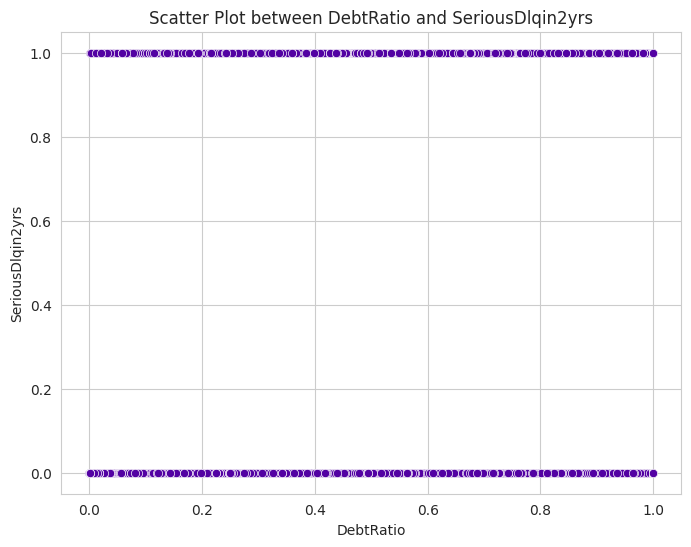

In [105]:
scatter_plot(combined_data, 'DebtRatio', 'SeriousDlqin2yrs')

### NumberOfOpenCreditLinesAndLoans Column

In [48]:
combined_data[["NumberOfOpenCreditLinesAndLoans"]].describe()

,NumberOfOpenCreditLinesAndLoans
count,"251,503.00"
mean,8.45
std,5.15
min,0.00
25%,5.00
50%,8.00
75%,11.00
max,85.00


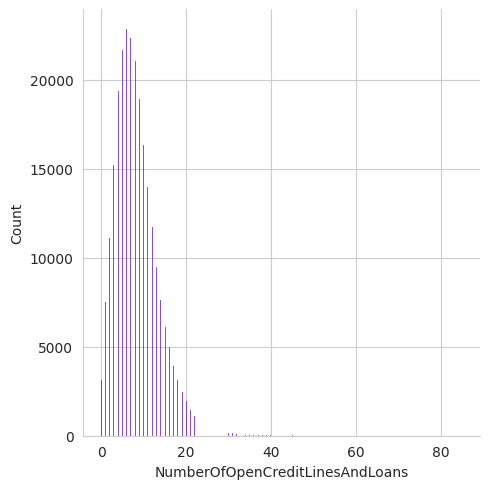

In [49]:
sns.displot(combined_data["NumberOfOpenCreditLinesAndLoans"])

In [50]:
prt_corr(combined_data, 'NumberOfOpenCreditLinesAndLoans', 'SeriousDlqin2yrs')

Correlation between NumberOfOpenCreditLinesAndLoans and SeriousDlqin2yrs: -0.029668568469318504


In [51]:
upper_bound = combined_data["NumberOfOpenCreditLinesAndLoans"].quantile(0.75)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['NumberOfOpenCreditLinesAndLoans'] > upper_bound, 'NumberOfOpenCreditLinesAndLoans'] = upper_bound

In [52]:
prt_corr(combined_data, 'NumberOfOpenCreditLinesAndLoans', 'SeriousDlqin2yrs')

Correlation between NumberOfOpenCreditLinesAndLoans and SeriousDlqin2yrs: -0.050748144856402624


### umberRealEstateLoansOrLines Column

In [53]:
combined_data[["NumberRealEstateLoansOrLines"]].describe([0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

,NumberRealEstateLoansOrLines
count,"251,503.00"
mean,1.02
std,1.12
min,0.00
25%,0.00
50%,1.00
75%,2.00
80%,2.00
90%,2.00
95%,3.00


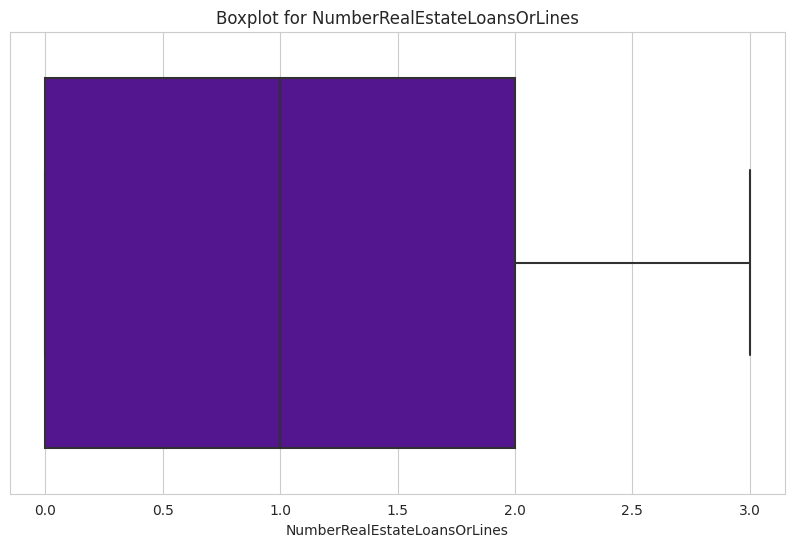

In [61]:
box_plot(combined_data, 'NumberRealEstateLoansOrLines')

In [55]:
prt_corr(combined_data, 'NumberRealEstateLoansOrLines', 'SeriousDlqin2yrs')

Correlation between NumberRealEstateLoansOrLines and SeriousDlqin2yrs: -0.00703811633598353


In [56]:
upper_bound = combined_data["NumberRealEstateLoansOrLines"].quantile(0.95)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['NumberRealEstateLoansOrLines'] > upper_bound, 'NumberRealEstateLoansOrLines'] = upper_bound

In [57]:
prt_corr(combined_data, 'NumberRealEstateLoansOrLines', 'SeriousDlqin2yrs')

Correlation between NumberRealEstateLoansOrLines and SeriousDlqin2yrs: -0.02626620593589926


### NumberOfDependents Column

In [58]:
combined_data[["NumberOfDependents"]].describe([0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

,NumberOfDependents
count,"244,953.00"
mean,0.76
std,1.12
min,0.00
25%,0.00
50%,0.00
75%,1.00
80%,2.00
90%,2.00
95%,3.00


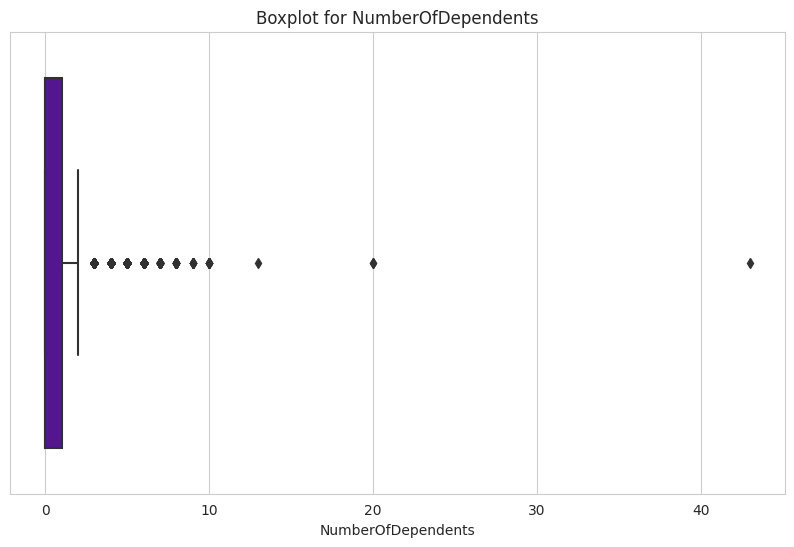

In [62]:
box_plot(combined_data, 'NumberOfDependents')

In [63]:
null_income_rows = combined_data['NumberOfDependents'].isnull().sum()

print("Number of rows where NumberOfDependents is NULL:", null_income_rows)

Number of rows where NumberOfDependents is NULL: 6550


In [64]:
upper_bound = combined_data["NumberOfDependents"].quantile(0.95)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['NumberOfDependents'] > upper_bound, 'NumberOfDependents'] = upper_bound

In [65]:
# Impute NumberOfDependents is null with the upper bound of NumberOfDependents
combined_data['NumberOfDependents'] = combined_data['NumberOfDependents'].replace(np.nan, upper_bound)

In [66]:
prt_corr(combined_data, 'NumberOfDependents', 'SeriousDlqin2yrs')

Correlation between NumberOfDependents and SeriousDlqin2yrs: 0.03804119219113706


### ManthlyIncom Columns

In [82]:
combined_data[["MonthlyIncome"]].describe()

,MonthlyIncome
count,"199,015.00"
mean,"6,834.76"
std,"25,876.65"
min,1.00
25%,"3,500.00"
50%,"5,442.00"
75%,"8,300.00"
max,"7,727,000.00"


**`MonthlyIncome` column**

Handling null values in the `MonthlyIncome` column depends on the nature of your data and the impact of missing values on your analysis. Here are a few common approaches:

**Imputation with Mean/Median:**

* Fill the null values with the mean or median of the column.
This is a simple method and can be appropriate if the null values are not systematically related to other variables.

**Imputation with Zero:**

* If it makes sense in your context, you can fill null values with zeros, especially if a zero value is a valid interpretation for missing income.

**Dropping Rows with Null Values:**

* If the number of rows with null values is small and removing them doesn't significantly impact your analysis, you might choose to drop those rows.

In [68]:
null_income_rows = combined_data['MonthlyIncome'].isnull().sum()

print("Number of rows where MonthlyIncome is NULL:", null_income_rows)

Number of rows where MonthlyIncome is NULL: 49834


In [69]:
zero_income_rows = (combined_data['MonthlyIncome'] == 0).sum()

print("Number of rows where MonthlyIncome is equal to 0:", zero_income_rows)

Number of rows where MonthlyIncome is equal to 0: 2654


In [70]:
combined_data['MonthlyIncome'].replace(0.0, np.nan, inplace=True)

In [71]:
one_income_rows = (combined_data['MonthlyIncome'] == 1).sum()

print("Number of rows where MonthlyIncome is equal to 1:", one_income_rows)

Number of rows where MonthlyIncome is equal to 1: 1012


In [92]:
median_salary_workforce = combined_data.loc[(combined_data['age'] <= 65)]['MonthlyIncome'].median()
median_salary_retired = combined_data.loc[(combined_data['age'] > 65)]['MonthlyIncome'].median()

print("workforce median salary:" + str(median_salary_workforce))
print("retiree median salary:" + str(round(median_salary_retired,0)))

workforce median salary:5541.0
retiree median salary:5000.0


In [99]:
# Replace MonthlyIncome based on conditions
combined_data['MonthlyIncome'] = np.where(
    (combined_data['MonthlyIncome'].isin([0, 1, None])) & (combined_data['age'] <= 65),
    median_salary_workforce,
    combined_data['MonthlyIncome']
)

combined_data['MonthlyIncome'] = np.where(
    (combined_data['MonthlyIncome'].isin([0, 1, None])) & (combined_data['age'] > 65),
    median_salary_retired,
    combined_data['MonthlyIncome']
)

In [101]:
null_income_rows = combined_data['MonthlyIncome'].isnull().sum()

print("Number of rows where MonthlyIncome is NULL:", null_income_rows)

Number of rows where MonthlyIncome is NULL: 0


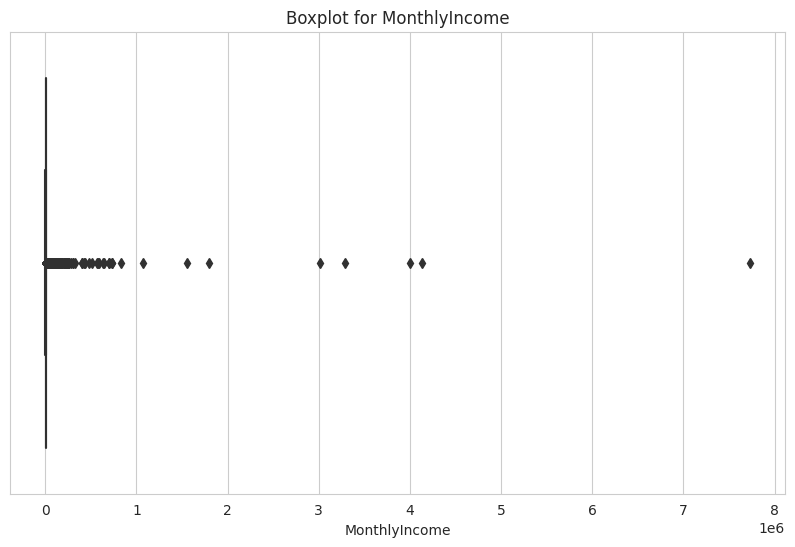

In [105]:
box_plot(combined_data, 'MonthlyIncome')

In [109]:
combined_data["MonthlyIncome"].describe([0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.999])

count     251,503.00
mean        6,555.50
std        23,022.71
min             2.00
25%         4,000.00
50%         5,541.00
75%         7,385.00
80%         8,233.00
85%         9,349.00
90%        10,700.00
95%        13,500.00
99.9%      75,000.00
max     7,727,000.00
Name: MonthlyIncome, dtype: float64

# مینیمم 2 هم مورد قبول نیست روی چارک های پایین هم یه تحقیقی انجام بده.

In [110]:
upper_bound = combined_data["MonthlyIncome"].quantile(0.999)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['MonthlyIncome'] > upper_bound, 'MonthlyIncome'] = upper_bound

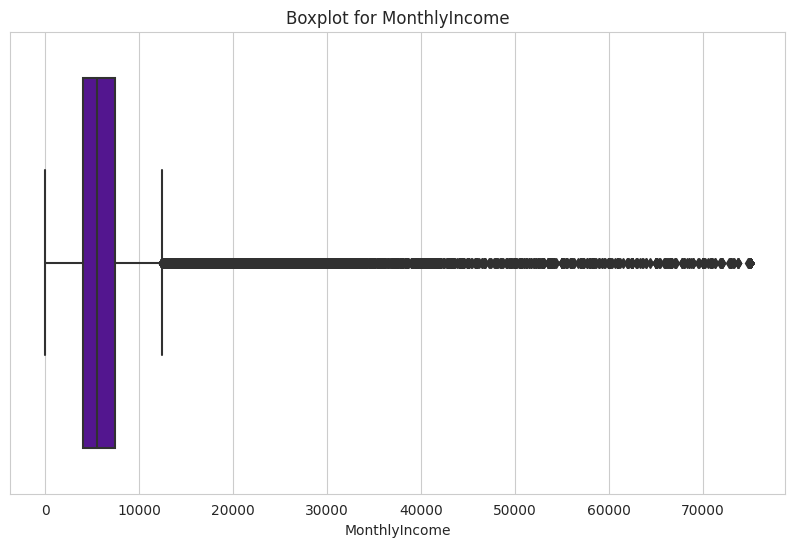

In [111]:
box_plot(combined_data, 'MonthlyIncome')

In [112]:
# Now you can easily separate them later
df_train = combined_data[combined_data['dataset'] == 'train'].drop('dataset', axis=1)
df_test = combined_data[combined_data['dataset'] == 'test'].drop('dataset', axis=1)

# Modeling

In [160]:
# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve,roc_auc_score, auc, classification_report, confusion_matrix, accuracy_score, f1_score, log_loss
from xgboost import XGBClassifier





def plot_roc_curve(false_positive_rate, true_positive_rate):
    """
        Purpose: To plot an ROC curve.
    """
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    plt.plot(false_positive_rate, true_positive_rate, linewidth=1)
    plt.plot([0,1],[0,1], "r--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")
    title_obj = ax.set_title("ROC Curve")
    plt.setp(title_obj, color='w')                     # Individual title colours.
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')       #set the color of xticks
    ax.tick_params(axis='y', colors='white')       #set the color of yticks
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.grid(which='major', color='gray', linestyle='--')
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


def plot_feature_importances(clf):
    """
    Purpose: To plot the importance of features fitted.
    Input: The model fit.
    """
    n_features = X.shape[1]

    # Get feature importances and corresponding feature names
    feature_importances = clf.feature_importances_
    feature_names = X.columns

    # Sort features based on importances
    sorted_idx = np.argsort(feature_importances)

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)
    plt.barh(range(n_features), feature_importances[sorted_idx], align='center')
    plt.yticks(np.arange(n_features), feature_names[sorted_idx])
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.grid(which='major', color='gray', linestyle='--')
    title_obj = ax.set_title("Feature Importance for Model")
    plt.setp(title_obj, color='w')  # Individual title colours.
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='x', colors='blue')  # set the color of xticks
    ax.tick_params(axis='y', colors='blue')  # set the color of yticks

    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

In [113]:
# Training data:
X = df_train.drop(['SeriousDlqin2yrs', 'ID'],axis=1)
y = df_train['SeriousDlqin2yrs']

# Testing data:
W = df_test.drop(['SeriousDlqin2yrs', 'ID'],axis=1)
z = df_test['SeriousDlqin2yrs']

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size = 0.2)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

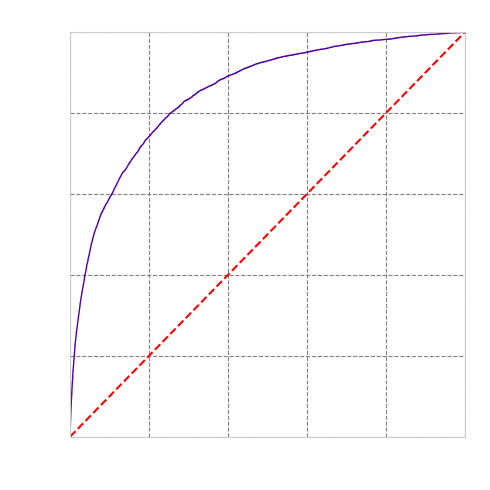

AUC Score:  0.8524067


In [138]:
# Assuming X_train_scaled and y_train are defined
logit = LogisticRegression(random_state=123, solver='saga', penalty='l1', class_weight='balanced', C=1.0, max_iter=500)
# logit = LogisticRegression(random_state=123, solver='liblinear', penalty='l1', class_weight=None, C=1.0, max_iter=100, dual=False, tol=0.0001, fit_intercept=True,intercept_scaling=1,  multi_class='ovr', verbose=2)
# logit.fit(X_train, y_train)
logit.fit(X_train_scaled, y_train)
# logit_scores_proba = logit.predict_proba(X_test)
logit_scores_proba = logit.predict_proba(X_train_scaled)
# logit_scores_proba = logit.predict(X_train_scaled)
preds = logit_scores_proba[:,1]  # predictions
fpr, tpr, threshold = roc_curve(y_train, preds)
# fpr, tpr, threshold = roc_curve(y_test, preds)
plot_roc_curve(fpr, tpr)
roc_auc = auc(fpr, tpr)
print('AUC Score: ', round(roc_auc, 7))


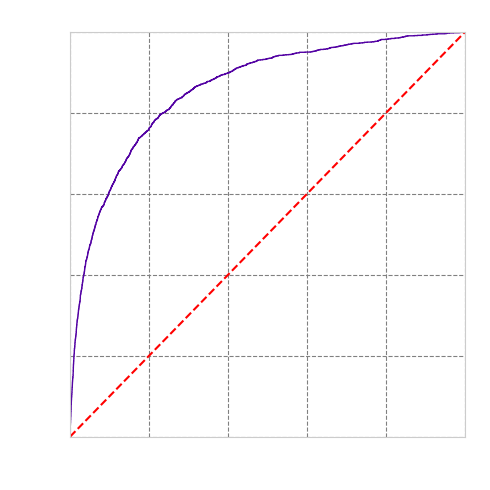

AUC Score :  0.859834


In [139]:
logit_scores_proba_val = logit.predict_proba(X_test_scaled)
preds = logit_scores_proba_val[:,1]
fpr_logit_val, tpr_logit_val, thresh_logit_val = roc_curve(y_test, preds)
plot_roc_curve(fpr_logit_val,tpr_logit_val)
print('AUC Score : ', round(roc_auc_score(y_test,preds),7))

## XG Boost

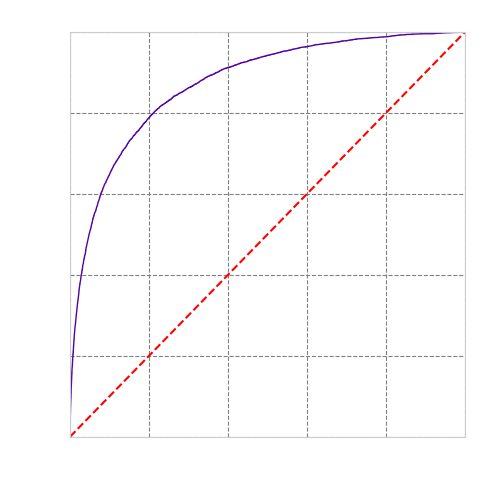

AUC Score :  0.8744839247181384


In [145]:
clf = XGBClassifier( random_state=123, n_estimators=150, learning_rate=0.05, max_depth=5)
clf.fit(X_train, y_train)
clf_scores_proba = clf.predict_proba(X_train)    # Predict class probabilities for X.
clf_preds = clf_scores_proba[::,1]
fpr, tpr, thresh = roc_curve(y_train, clf_preds)
plot_roc_curve(fpr,tpr)
print('AUC Score : ', (roc_auc_score(y_train,clf_preds)))

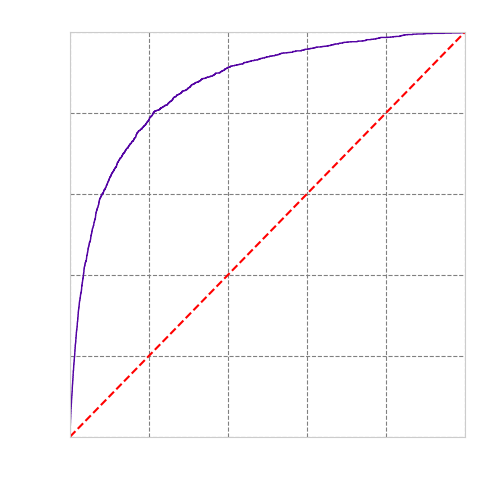

AUC Score :  0.8688482
Accuracy: 93.66%


In [146]:
clf_scores_proba_val = clf.predict_proba(X_test)
preds = clf_scores_proba_val[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
plot_roc_curve(fpr,tpr)
print('AUC Score : ', round(roc_auc_score(y_test,preds),7))

# evaluate predictions
y_pred = clf.predict(X_test)
preds = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

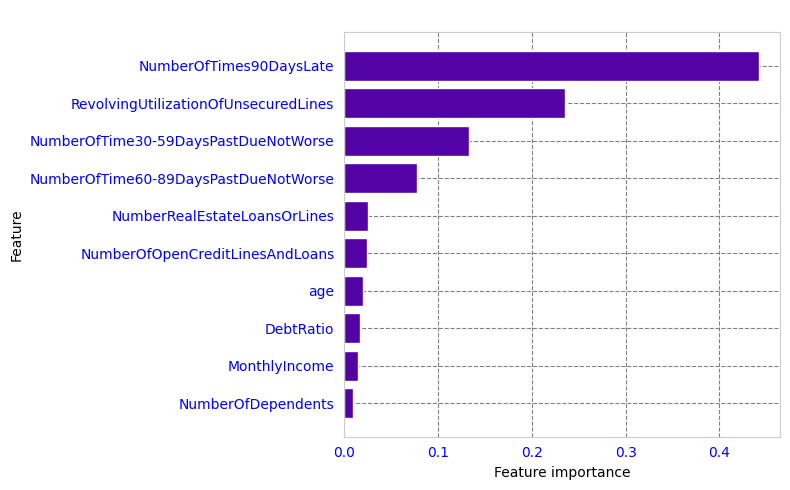

In [161]:
plot_feature_importances(clf)

## Gradient Boosting

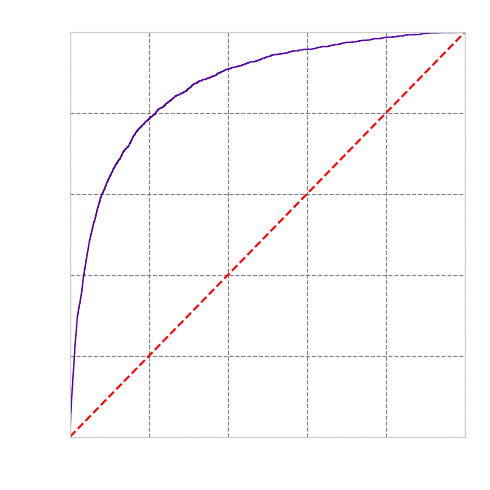

AUC Score :  0.8688424094671122


In [179]:
# Create a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=123)

# Fit the model on the training data
gb_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_prob = gb_classifier.predict_proba(X_test_scaled)[:, 1]  # Predict probabilities for positive class
fpr, tpr, thresh = roc_curve(y_test, y_prob)
plot_roc_curve(fpr, tpr)
print('AUC Score : ', (roc_auc_score(y_test, y_prob)))

# Convert probabilities to binary predictions based on a threshold (you can adjust the threshold as needed)
# threshold = 0.5
# y_pred = (y_prob >= threshold).astype(int)

In [174]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\n\nConfusion Matrix:")
print(conf_matrix)
print("\n\nClassification Report:")
print(classification_rep)

Accuracy: 0.8402


Confusion Matrix:
[[24102  3912]
 [  882  1104]]


Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     28014
         1.0       0.22      0.56      0.32      1986

    accuracy                           0.84     30000
   macro avg       0.59      0.71      0.61     30000
weighted avg       0.92      0.84      0.87     30000



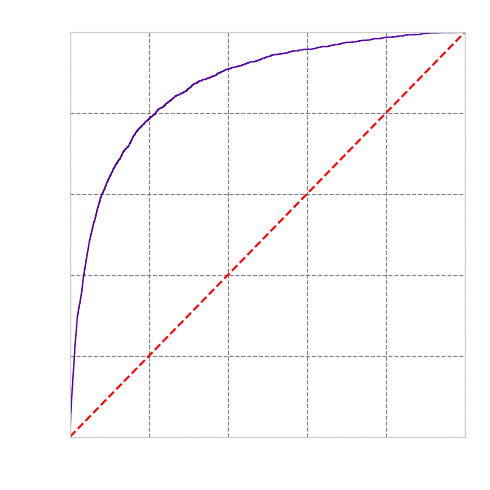

AUC Score :  0.8688424


In [180]:
clf_scores_proba_val = gb_classifier.predict_proba(X_test_scaled)
preds = clf_scores_proba_val[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
plot_roc_curve(fpr,tpr)
print('AUC Score : ', round(roc_auc_score(y_test,preds),7))

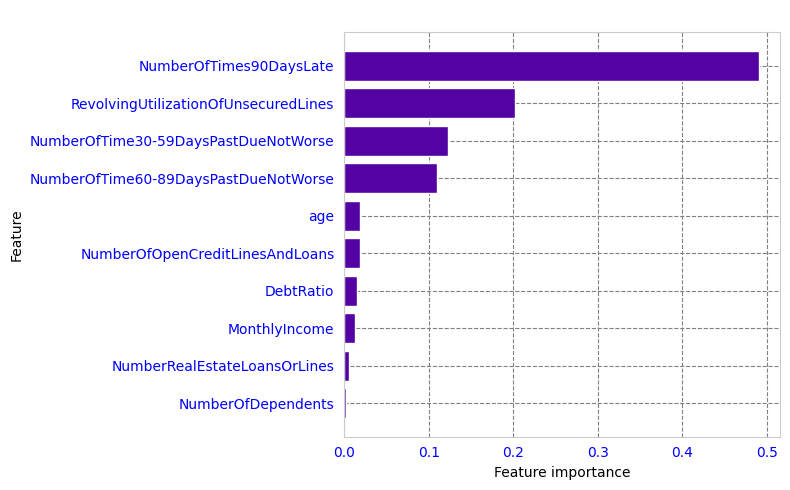

In [176]:
plot_feature_importances(gb_classifier)

## Ensemble

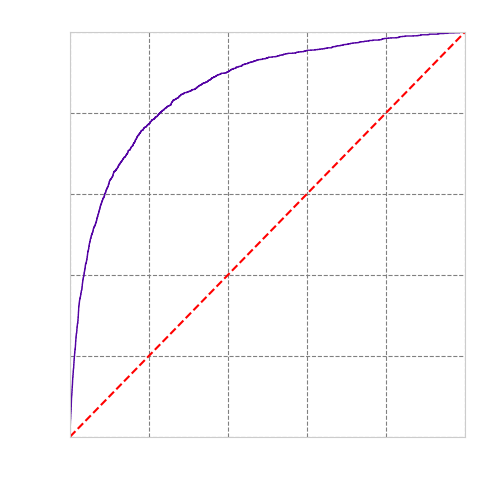

AUC Score :  0.8633821


In [181]:
model1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=123)
model1.fit(X_train_scaled, y_train)
pred1 = model1.predict_proba(X_test_scaled)    # Predict class probabilities for X.
model1.score(X_test_scaled,y_test)


model2 = XGBClassifier( random_state=123, n_estimators=150, learning_rate=0.05, max_depth=5)
model2.fit(X_train_scaled, y_train)
pred2 = model2.predict_proba(X_test)
model2.score(X_test_scaled,y_test)


model3 = LogisticRegression(random_state=123, solver='saga', penalty='l1', class_weight='balanced', C=1.0, max_iter=500)
model3.fit(X_train_scaled, y_train)
pred3 = model3.predict_proba(X_test_scaled)
model3.score(X_test_scaled,y_test)

finalpred = (pred1 + pred2 + pred3)/3

preds = finalpred[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
plot_roc_curve(fpr,tpr)
print('AUC Score : ', round(roc_auc_score(y_test,preds),7))

In [184]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\n\nConfusion Matrix:")
print(conf_matrix)
print("\n\nClassification Report:")
print(classification_rep)

Accuracy: 0.8402


Confusion Matrix:
[[24102  3912]
 [  882  1104]]


Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     28014
         1.0       0.22      0.56      0.32      1986

    accuracy                           0.84     30000
   macro avg       0.59      0.71      0.61     30000
weighted avg       0.92      0.84      0.87     30000

